# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Answer

The algorithm is to use Newton's Method with each step of computing 'p' using KKT solver. 

More specifically, I will write the functions described in the prompt, which includes compute_gradient of the cost function f (delta f), compute_hessian of the function f (H), compute_constraints of the constraint function g (delta G and g), and line_search function.

In the main function, I construct a loop with break condition as the convergence condition. In each iteration, the program finds a new pair of delta x and delta lambda by solving the KKT using the gradient and hessian of the current x, and cost (f_trial) and constraint violation (g_trial) are also updated accordingly to help the line search function.







$$
\frac{\partial J}{\partial \theta_n} = 20(\theta_n - \pi)
$$

$$
\frac{\partial J}{\partial \omega_n} = 0.2\omega_n
$$

$$
\frac{\partial J}{\partial u_n} = 0.2u_n
$$




In [281]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import pendulum

def compute_cost(theta, omega, u):
    cost = np.sum(10 * (theta - np.pi)**2 + 0.1 * omega**2 + 0.1 * u**2)
    return cost

def compute_gradient(theta, omega, u):
    N_plus_1 = len(theta)
    grad = np.zeros(3 * N_plus_1)
    
    grad[0::3] = 20 * (theta - np.pi)
    grad[1::3] = 0.2 * omega
    grad[2::3] = 0.2 * u
    
    return grad





$$
\frac{\partial^2 J}{\partial \theta_n^2} = 20
$$

$$
\frac{\partial^2 J}{\partial \omega_n^2} = 0.2
$$

$$
\frac{\partial^2 J}{\partial u_n^2} = 0.2
$$

$$
\frac{\partial^2 J}{\partial \theta_n \partial \omega_n} = 0
$$

$$
\frac{\partial^2 J}{\partial \theta_n \partial u_n} = 0
$$

$$
\frac{\partial^2 J}{\partial \omega_n \partial u_n} = 0
$$

In [282]:

from scipy.linalg import block_diag
def compute_hessian(N):
    block = np.array([
        [20,   0,   0],
        [ 0, 0.2,   0],
        [ 0,   0, 0.2]
    ])
    blocks = [block] * (N + 1)
    H = block_diag(*blocks)
    return H


In [283]:

def compute_constraints(theta, omega, u, dt, g_const):
    """
    Returns:
    - G: Jacobian matrix of constraints (size 2N + 2 x 3*(N+1))
    - g: Constraint residuals vector (size 2N + 2)
    """
    N = len(u) - 1
    num_constraints = 2 * N + 2  # Added 2 for initial conditions!
    size = 3 * (N + 1)

    G = np.zeros((num_constraints, size))
    g_vec = np.zeros(num_constraints)

    for n in range(N):
        # Current and next indices for theta, omega, and u
        idx_theta_n = 3 * n
        idx_omega_n = 3 * n + 1
        idx_u_n = 3 * n + 2

        idx_theta_np1 = 3 * (n + 1)
        idx_omega_np1 = 3 * (n + 1) + 1

        # Constraint 1: theta_{n+1} - theta_n - dt * omega_n = 0
        c_theta = theta[n + 1] - theta[n] - dt * omega[n]
        g_vec[2 * n] = c_theta

        G[2 * n, idx_theta_n] = -1
        G[2 * n, idx_theta_np1] = 1
        G[2 * n, idx_omega_n] = -dt

        # Constraint 2: omega_{n+1} - omega_n - dt * (u_n - g * sin(theta_n)) = 0
        c_omega = omega[n + 1] - omega[n] - dt * (u[n] - g_const * np.sin(theta[n]))
        g_vec[2 * n + 1] = c_omega

        G[2 * n + 1, idx_theta_n] = dt * g_const * np.cos(theta[n])
        G[2 * n + 1, idx_omega_n] = -1
        G[2 * n + 1, idx_omega_np1] = 1
        G[2 * n + 1, idx_u_n] = -dt

    # Add initial condition constraints! Super Important!
    # Constraint 3: theta_0 = 0
    G[-2, 0] = 1
    g_vec[-2] = theta[0]  # Should be zero

    # Constraint 4: omega_0 = 0
    G[-1, 1] = 1
    g_vec[-1] = omega[0]

    return G, g_vec

In [284]:

def solve_kkt(H, grad_J, G, g_vec):
    """
    Returns:
    - delta_x: Search direction for variables (size 3*(N+1))
    - delta_lambda: Search direction for Lagrange multipliers (size 2N)
    """
    num_vars = H.shape[0]          # 3*(N+1)
    num_constraints = G.shape[0]  # 2N
    
    KKT_matrix = np.zeros((num_vars + num_constraints, num_vars + num_constraints))
    KKT_matrix[:num_vars, :num_vars] = H
    KKT_matrix[:num_vars, num_vars:num_vars + num_constraints] = G.T
    KKT_matrix[num_vars:num_vars + num_constraints, :num_vars] = G
    
    rhs = - np.concatenate([grad_J, g_vec])
    
    try:
        solution = solve(KKT_matrix, rhs)
    except np.linalg.LinAlgError:
        epsilon = 1e-6
        KKT_matrix[:num_vars, :num_vars] += epsilon * np.eye(num_vars)
        solution = solve(KKT_matrix, rhs)
    
    # Extract delta_x and delta_lambda
    delta_x = solution[:num_vars]
    delta_lambda = solution[num_vars:]
    
    return delta_x, delta_lambda

In [285]:
def compute_constraint_violation(g_vec, x_vec = None):
    violation = np.sum(np.abs(g_vec))
    if x_vec is not None:
        relevant_elements = x_vec[2::3]
        violations_above = np.maximum(relevant_elements - 4, 0)
        violations_below = np.maximum(-4 - relevant_elements, 0)
        violation += np.sum(violations_above + violations_below)
    return violation

def split_variables(x_guess):
    theta = x_guess[0::3]
    omega = x_guess[1::3]
    u = x_guess[2::3]
    return theta, omega, u

def simple_filter_line_search(x_guess, p_x, lambda_guess, p_lambda, f_best, g_best, dt, g_const):
    rho=0.5
    max_iter=10
    alpha = 1
    
    for _ in range(max_iter):
        # Current x
        x_trial = x_guess + alpha * p_x

        # Compute cost
        theta_trial, omega_trial, u_trial = split_variables(x_trial)
        f_trial = compute_cost(theta_trial, omega_trial, u_trial)

        # Compute constraints violation
        __, g_vec_trial = compute_constraints(theta_trial, omega_trial, u_trial, dt, g_const)
        g_trial_violation = compute_constraint_violation(g_vec_trial, x_trial)
        
        if f_trial < f_best or g_trial_violation < g_best:
            # Update lambda, yes I update lambda here inside line search
            lambda_new = (1 - alpha) * lambda_guess + alpha * p_lambda
            return x_trial, lambda_new, f_trial, g_trial_violation, alpha
        
        alpha *= rho
    
    print("No acceptable alpha found.", alpha)
    # If no acceptable alpha found, return the last trial; may diverge
    return x_trial, lambda_guess, f_trial, g_trial_violation, alpha


In [286]:

def check_convergence(grad_L, c_vec, tol=1e-4):
    optimality = np.linalg.norm(grad_L, np.inf)
    feasibility = np.linalg.norm(c_vec, np.inf)
    return optimality < tol and feasibility < tol

def sqp_solver():
    N = 300
    dt = 0.01
    g_const = 9.81
    max_iter = 100
    tol = 1e-4

    # Initial guess of x
    x_vec = np.zeros(3 * (N + 1))

    # Lambda_guess is not used in line search but line search updates it
    # and it's necessary to calculate the gradient to check for convergence
    lambda_vec = np.zeros(2 * N + 2)
    
    # Initially, the best cost and constraint violation are infinity
    f_best = np.inf
    g_best = np.inf

    cost_history = []
    constraint_violation_history = []
    alpha_history = []
    
    for iteration in range(1, max_iter + 1):
        theta, omega, u = split_variables(x_vec)

        # Check for convergence
        grad_J = compute_gradient(theta, omega, u)
        H = compute_hessian(N)
        G, g = compute_constraints(theta, omega, u, dt, g_const)
        grad_L = grad_J + G.T @ lambda_vec

        if check_convergence(grad_L, g, tol):
            print(f"Converged in {iteration - 1} iterations.")
            break
        
        # Find the direction of the step by solving the KKT system
        delta_x, delta_lambda = solve_kkt(H, grad_J, G, g)
        
        # Perform the simple filter line search to find step size alpha,
        # which takes the direction delta_x and delta_lambda, and returns
        # the updated x and lambda. 
        # Current cost, violation, and alpha are also returned for plotting
        x_vec, lambda_vec, f_trial, g_trial_violation, alpha = simple_filter_line_search(
            x_vec, delta_x, lambda_vec, delta_lambda, f_best, g_best, dt, g_const
        )
        
        # Update the best values of cost and constraint violation
        if f_trial < f_best:
            f_best = f_trial
        if g_trial_violation < g_best:
            g_best = g_trial_violation
        
        # Update history for plotting
        cost_history.append(f_trial)
        constraint_violation_history.append(g_trial_violation)
        alpha_history.append(alpha)
        
        print(f"Iteration {iteration}: Cost = {f_trial:.3f}, Constraint Violation = {g_trial_violation:.3f}, Alpha = {alpha:.3f}")
    
    else:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
    
    return theta, omega, u, cost_history, constraint_violation_history, alpha_history


In [287]:

def plot_solution(theta, omega, u, dt):
    N = len(u) - 1
    time = np.linspace(0, N * dt, N + 1)

    plt.figure(figsize=(14, 10))
    
    # Plot Theta
    plt.subplot(3, 1, 1)
    plt.plot(time, theta, label='Angle θ (rad)', color='blue')
    plt.axhline(np.pi, color='red', linestyle='--', label='Desired θ = π rad')
    plt.title('Pendulum Angle Over Time')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle θ (rad)')
    plt.legend()
    plt.grid(True)
    
    # Plot Omega
    plt.subplot(3, 1, 2)
    plt.plot(time, omega, label='Angular Velocity ω (rad/s)', color='green')
    plt.title('Pendulum Angular Velocity Over Time')
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity ω (rad/s)')
    plt.legend()
    plt.grid(True)
    
    # Plot Control Input u
    plt.subplot(3, 1, 3)
    plt.plot(time, u, label='Control Input u (N·m)', color='purple')
    plt.title('Control Input Over Time')
    plt.xlabel('Time [s]')
    plt.ylabel('Control Input u (N·m)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def plot(constraint_violation_hist, cost_hist, alpha_hist):
    """
    Plots Constraint Violation, Cost Function Value, and Step Size over Iterations in a Single Figure.
    
    Parameters:
    - constraint_violation_hist (list or np.ndarray): History of total constraint violations per iteration.
    - cost_hist (list or np.ndarray): History of cost function values per iteration.
    - alpha_hist (list or np.ndarray): History of step sizes (alpha) per iteration.
    """
    # Determine the number of iterations
    iterations = range(1, len(constraint_violation_hist) + 1)
    
    # Create a figure with 3 subplots (3 rows, 1 column)
    fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.4)
    
    # --- Plot Constraint Violation ---
    axs[0].plot(iterations, constraint_violation_hist, marker='o', color='orange', linestyle='-', linewidth=2, markersize=6)
    axs[0].set_title('Constraint Violation per Iteration', fontsize=16)
    axs[0].set_ylabel('Total Constraint Violation', fontsize=14)
    axs[0].set_yscale('log')  # Logarithmic scale for better visibility of changes
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    
    # --- Plot Cost Function Value ---
    axs[1].plot(iterations, cost_hist, marker='s', color='green', linestyle='-', linewidth=2, markersize=6)
    axs[1].set_title('Cost Function Value per Iteration', fontsize=16)
    axs[1].set_ylabel('Cost \( J \)', fontsize=14)
    axs[1].set_yscale('log')  # Logarithmic scale for better visibility of changes
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    
    # --- Plot Step Size Alpha ---
    axs[2].plot(iterations, alpha_hist, marker='^', color='purple', linestyle='-', linewidth=2, markersize=6)
    axs[2].set_title('Step Size \( \alpha \) per Iteration', fontsize=16)
    axs[2].set_xlabel('Iteration', fontsize=14)
    axs[2].set_ylabel('Step Size \( \alpha \)', fontsize=14)
    axs[2].grid(True, linestyle='--', linewidth=0.5)
    axs[2].tick_params(axis='both', which='major', labelsize=12)
    
    # Optional: Add a main title for the entire figure
    fig.suptitle('Optimization Metrics Over Iterations', fontsize=18, y=0.95)
    
    # Display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
    plt.show()


<>:98: SyntaxWarning: invalid escape sequence '\('
<>:105: SyntaxWarning: invalid escape sequence '\('
<>:107: SyntaxWarning: invalid escape sequence '\('
<>:98: SyntaxWarning: invalid escape sequence '\('
<>:105: SyntaxWarning: invalid escape sequence '\('
<>:107: SyntaxWarning: invalid escape sequence '\('
/var/folders/vv/xg94_m256r75qrc_b0bcqy7w0000gn/T/ipykernel_24494/2569952053.py:98: SyntaxWarning: invalid escape sequence '\('
  axs[1].set_ylabel('Cost \( J \)', fontsize=14)
/var/folders/vv/xg94_m256r75qrc_b0bcqy7w0000gn/T/ipykernel_24494/2569952053.py:105: SyntaxWarning: invalid escape sequence '\('
  axs[2].set_title('Step Size \( \alpha \) per Iteration', fontsize=16)
/var/folders/vv/xg94_m256r75qrc_b0bcqy7w0000gn/T/ipykernel_24494/2569952053.py:107: SyntaxWarning: invalid escape sequence '\('
  axs[2].set_ylabel('Step Size \( \alpha \)', fontsize=14)


In [288]:

theta_opt, omega_opt, u_opt, cost_hist, constraint_violation_hist, alpha_hist = sqp_solver()



Iteration 1: Cost = 14728.331, Constraint Violation = 2919.293, Alpha = 1.000
Iteration 2: Cost = 5795.072, Constraint Violation = 1068.533, Alpha = 1.000
Iteration 3: Cost = 4682.570, Constraint Violation = 481.030, Alpha = 1.000
Iteration 4: Cost = 4682.216, Constraint Violation = 481.112, Alpha = 1.000
Iteration 5: Cost = 4682.216, Constraint Violation = 481.123, Alpha = 1.000
Iteration 6: Cost = 4682.216, Constraint Violation = 481.124, Alpha = 1.000
Converged in 6 iterations.


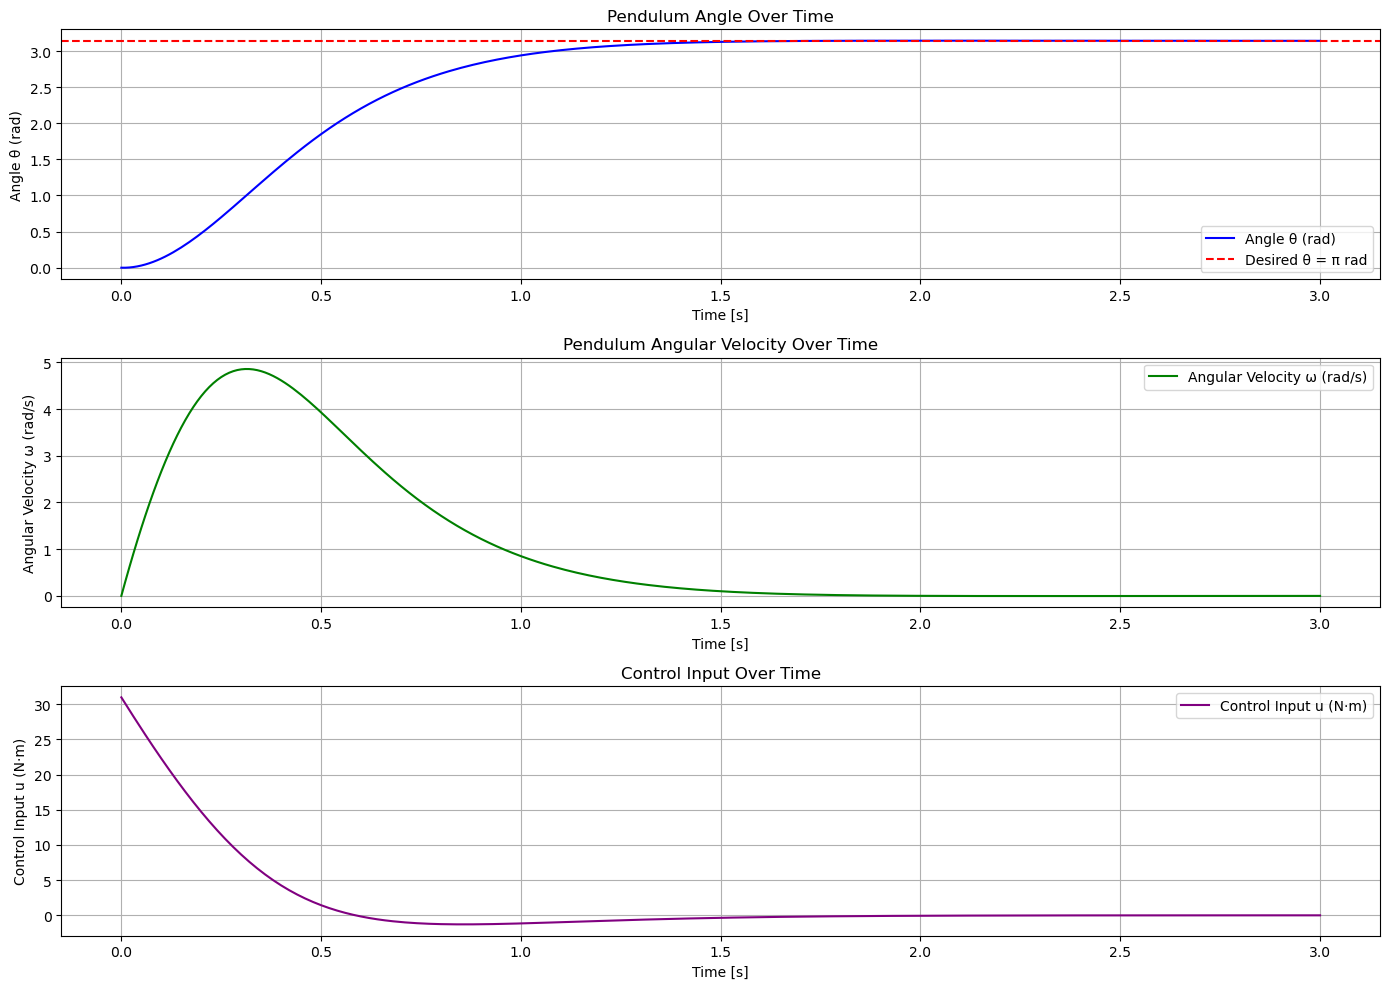

/var/folders/vv/xg94_m256r75qrc_b0bcqy7w0000gn/T/ipykernel_24494/2569952053.py:115: UserWarning: Glyph 7 () missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
/Users/Apple/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


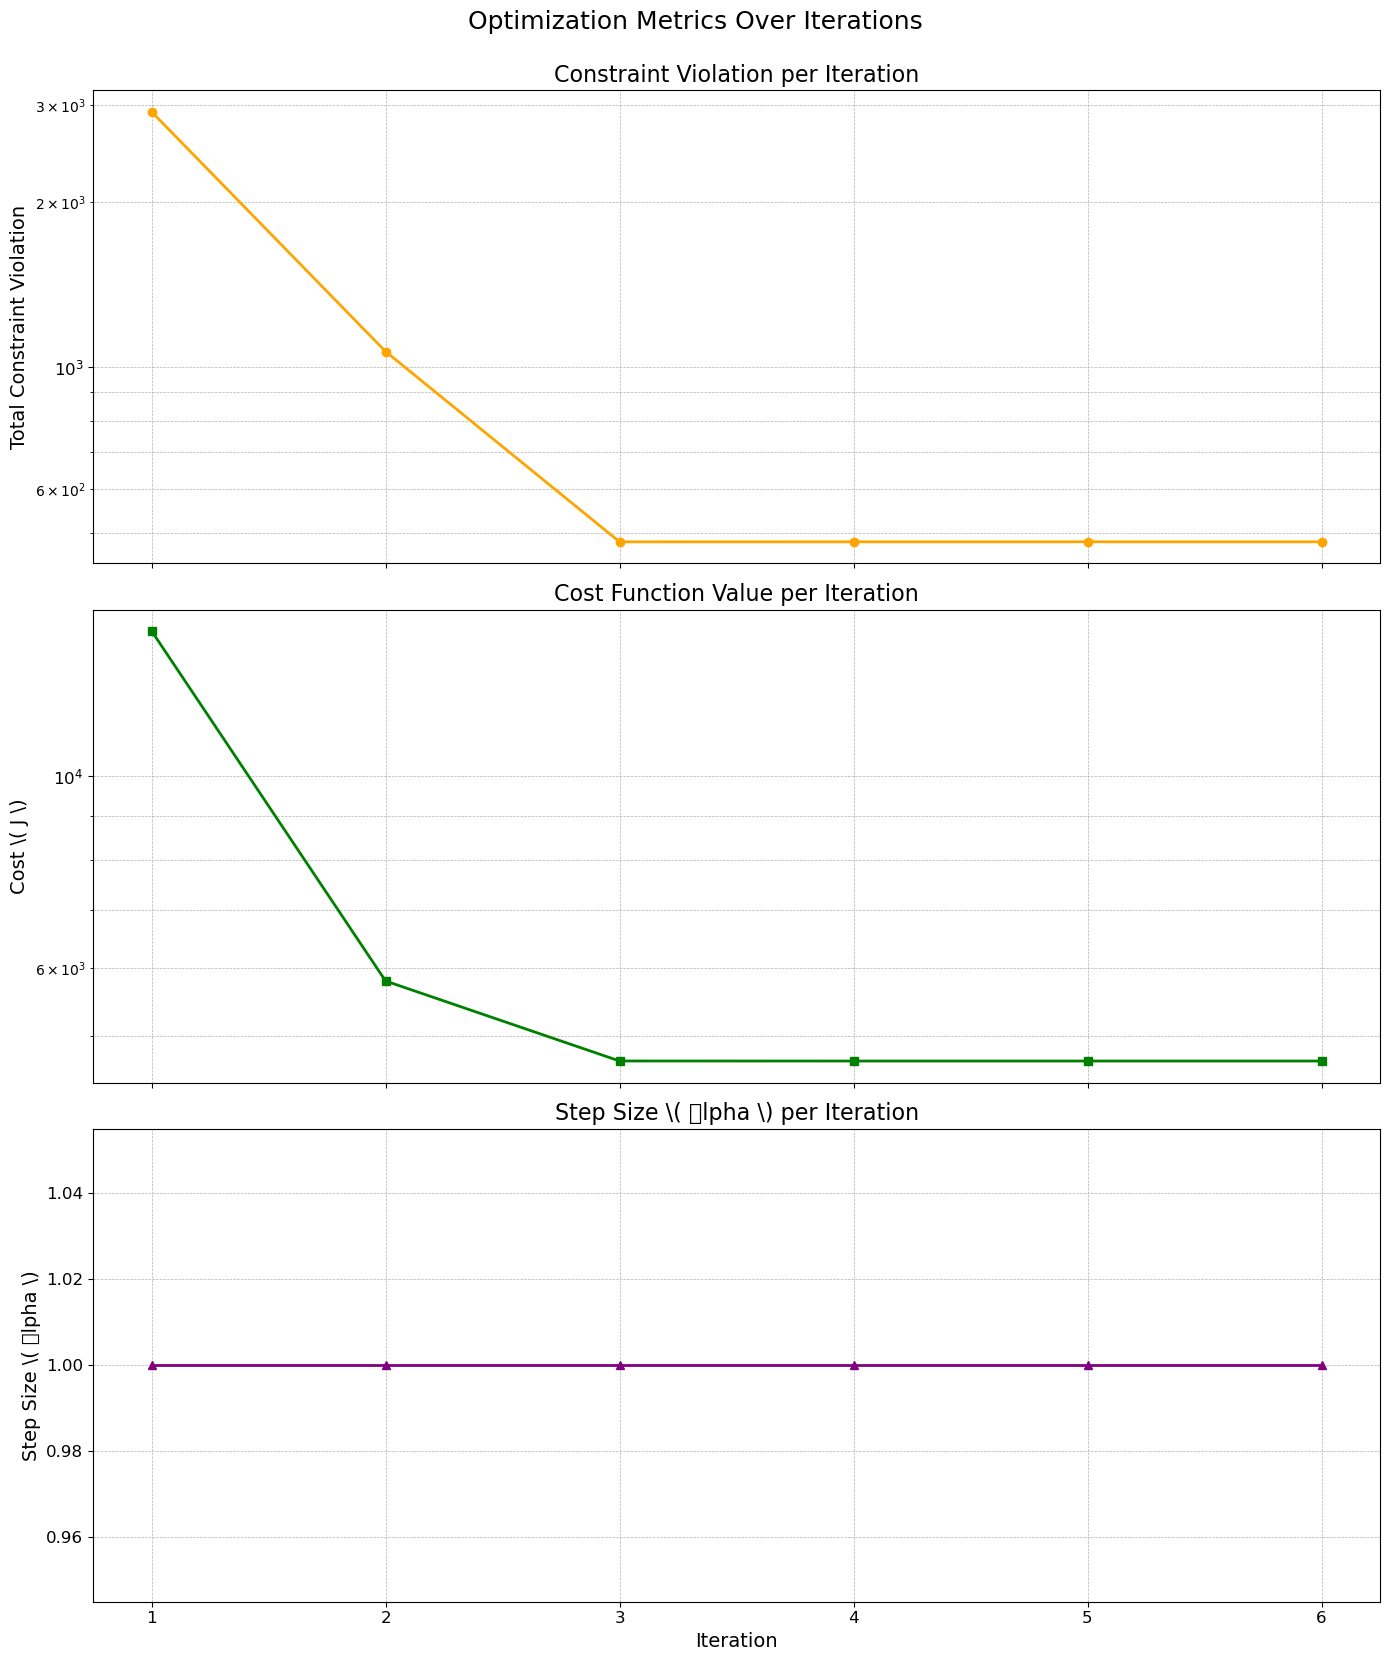

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMdBtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DM5liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHZLWaOMQVpiq
d+MNlrfnTLNZcruzr5rzhlxaWGClILil3tL0I/cDT7aMEJ8wwmRz7fdf9CSoxmt0gTXN9os4nhWn
l2UQACEghzJhhRaqP0gnAnXegb691Za5bTR2HG2BPjeYTWwZgJiDzIN6CTy2SeGaRvcN2e8Dl2Ll
XRBUbu1QsYuhIwdmdlN5Bh8NZ/pGVHWdBsk5TkwgBAy3nEbuhVIBtN8a2zw8swraa9ckoUhdzYQ7
e12ESbDJ+6GzM3hKzkSdtN04ClX1PcYg6h0Qa4fTjWlgSpko/TxizYYhvApSZzPLb0S+BqmxoPI/
L1S6j54SYGR2VIyFmkpORl+nrmLfBFnZiXqQgVF7oHLDB25/1alP9tAlxm3NnTX1dmzZ5Fth1oSg
lfqRQXrI0QoKAJ+3VndI+NaMs/SYEBNdMBWcDL524GInWEZ3STjgILjkwm/vsjaR8rsRpLybmwcQ
/EmDsuEWKUZTeaulMdlSl5nCNo7JJtmgjj6eSDDvUgy8w6hdtOUXs/cezo38NkxLkVRncjiFxawG
l74gsIsKQAAAAwAAAwAAAwALts6IKafZCn0VxJfvCWHSZM0KD+tlFkn5+FZciT1n9XeFVEmYoyyQ
39KxX+z0gWQqDMRIySepnUHn5z7KbSXv2qb92YzjZK8VLv3vuXmp/1vD5nV0388zJxmKrIfDHXc5
8DSwheS5Sj8qDP60Emgr/a0xLy1D+RXcZjFFYLWEnuiO19Mf+WEBNQqLiKagMk4WxKuUFUeGHNBy
revrK+cJkUZ+eftsDTwE6z/SlDdwsrfu9WO68fqFkdtp8j+LfgKTo1jaNKczKW65lbAUvbRRi++1
45Ayr+x+E0PLrpaCznioU8e37N1w0VbsFaw5ZgHtaOZ+y9iL8DtjVnCDsAF5ZGvhK5uT/H1KFO2+
d9f/gY1sGLlkIYbrLY3GZH70+cokvSSQBhEbfnadKwO1Z3h8jke4amW7HBK7mB0v6+3ezVgAPV/2
taoAAAMAAAMAYluyoGsUlKj4NkY/ZLJzyFtfG720NxxD5qNyhi9DtEMzyW3SRXnMAlsH5PROPO2c
NpnN+iHqHMD0jqnxAjeIYKouK5+gIpCg0KoNsxcCj5LxgiE8mhsrDtGavuJLhZoktKypWDrqVehF
gaZ/vAhR2p+AYlz6AYYuivYK+40Hz5ainuMad1gAx/IeYOU0rRqqpX+yl4oX74jXn/DybIXi5AK9
0dRENoYZxMcTEPn7+/w/7F4T3QoCjVN2VXjQSDo+bKH5eSRcphkWAhNDpzvTPjU7CaaK8ayymzfk
AFNmSR6PAwiQGuU07a9zvm8VxkZQStd+F5wJ3Ed5+Z2Xv4UehB4Edv5ZY/XdSeyyXLfp1QGN0G2R
CtyRqQY3D2mqb71EfXSBJIUQyLTAQTui2Z0r9FD6jXybptQniucac/GP4KNNPCaaE1W+yQ3ToP4L
TxjlaZjok4knV4tuckfILQxsC4qIHmROE+y709dsO16+6VyVwh24/Y6ORC5cri2ixmrZ+XX7Meah
SQ/DScJiYyVuBVqgP3ECSvncL8fVGx9sPUzWtjItunM8xhcZYOlCHDEAnOXexFL6N1zgwAAAAwAA
AwIvaT+j76rHWIh9FoykLLK7AG/vKNh0hGXOR8O260r5uxccHUF0DFWc+1Z78Ts2kXffPIvE3LYF
KMEILuDaYGTdvNElwnDlx1JjdJYxlTPBCRokFx1W7uT6Qq/Fi4NsGaaynrhHNR7fhOecLoeTcvxF
4EthP6STrETQ+WuULevNVKi5WKQfQLt2Pyu9eEGEqw2fK1w9pG5AFD52JPSZ1GJJib0IV7p42DLk
sKZNoVXZik6AwUlyvIL/X/aLtW8yJWw/03O5lfmtBAZP66zaHN+RrWazbRJJTqgBZ38fheYg0XQL
DMFxsTLEoOzcfE9p+nDPO+wAxUE8I0d4KQ3OjjrP9STYouuzBW+yEyrgyL/9jVCb8Tb4Lav4Rc07
QnjdtTgbNYBCtjWGoV0rCkjnYTMVghASOVfnDdqB+aIXTJSzA8m0Xx3D56fmbnrTB3yFKHkzvN49
RR/2cfCLb7PqIjz0wp5p+ErKFb8eZEZpZp+aKIyNeceKzKavGcKXsYyBbhKY7G8nfnoAx7zXD6gG
87vetrwTNtSH/cAAAAMAAAMAhw2dt+qMfVgQNBwWDobvEMl9LcpbI+d52GudIO5unKQnQbuYy6qk
adCcsH5wnxFMDc927GVw8EjsenGBHcdd/kwza7eMKs+1YW8JaZrXGlCzafWdJhDJtGy2U4oDUPVN
pw0iadxmfK46pxUNoIR42iQyR/ooUi8tPGt4SMFFnwEIopwlJe2WJL/N01BXbJEPhNrc/iXimQW5
rcmWOqWwbl9zLaKVfksxIlcPfNVE98RB2YYoU1qPoNpJECaobzD0FOqNHabMGTMfvKEJDrESOU07
uifCO9AxHP5Irc6KcwRmnPNW+Jpv+JKeUztC7QeY7tcaWVOFdBapJEIxAnSXSo/wX8kUVsiUg6Nh
6wm5EWb9UDZ54//shGNDzIidJUHnGF9tz3DBvxZpdU9tOMpwTfqfVcXDWZvry01IcqBmlUf6q9ia
UBDgtxfM0le1H8iAYGeq4/A0bV5X9mdX8/sjPD2lPxtcw1Em/x4jYR/TiTwMuNzpn8IN5oYIsE4O
gxWB2ixpH2yiL/s1wk4vB

In [289]:

%matplotlib inline
plot_solution(theta_opt, omega_opt, u_opt, dt=0.01)
plot(constraint_violation_hist, cost_hist, alpha_hist)

x0 = np.array([[0], [0]])

u_for_animation = u_opt[:-1].reshape(1, -1)
pendulum.animate_robot(x0, u_for_animation)

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [290]:
from qpsolvers import solve_qp, Problem, solve_problem


In [291]:


def solve_inequality_kkt(H, grad_J, G, g_vec, x_vec):
    """
    Returns:
    - delta_x: Search direction for variables (size 3*(N+1))
    - delta_lambda: Search direction for Lagrange multipliers (size 2N)
    """
    num_vars = H.shape[0]          # 3*(N+1)
    num_constraints = G.shape[0]  # 2N + 2
    
    P = H
    q = grad_J
    # G = np.zeros(num_vars)
    # h = np.array([np.inf])
    A = G
    b = - g_vec
    lb = np.full(num_vars, -np.inf)
    ub = np.full(num_vars, np.inf) 
    lb[2::3] = - 4 - x_vec[2::3]
    ub[2::3] = 4 - x_vec[2::3]
    # lb = -4 * np.ones(num_vars)
    # ub = 4 * np.ones(num_vars)

    problem = Problem(P, q, np.zeros(num_vars).reshape(1, -1), np.array([np.inf]), A, b, lb, ub)
    solution = solve_problem(problem, solver="cvxopt")

    # Extract delta_x and delta_lambda
    print(solution.x)
    delta_x = solution.x
    delta_lambda = solution.y
    # delta_x = qpsolvers.solve_qp(P, q, G=None, h=None, A=G, b=-c_vec, lb=lb, ub=ub, solver='proxqp')
    
    return delta_x, delta_lambda

def check_convergence(grad_L, g_vec, tol=1e-4):
    optimality = np.linalg.norm(grad_L, np.inf)
    feasibility = np.linalg.norm(g_vec, np.inf)
    return optimality < tol and feasibility < tol

def compute_constraint_violation(g_vec, x_vec = None):
    violation = np.sum(np.abs(g_vec))
    if x_vec is not None:
        relevant_elements = x_vec[2::3]
        violations_above = np.maximum(relevant_elements - 4, 0)
        violations_below = np.maximum(-4 - relevant_elements, 0)
        violation += np.sum(violations_above + violations_below)
    return violation

In [292]:

def sqp_inequality_solver():
    N = 300
    dt = 0.01
    g_const = 9.81
    max_iter = 100
    tol = 1e-4

    # Initial guess of x
    x_vec = np.zeros(3 * (N + 1))

    # Lambda_guess is not used in line search but line search updates it
    # and it's necessary to calculate the gradient to check for convergence
    lambda_vec = np.zeros(2 * N + 2)
    
    # Initially, the best cost and constraint violation are infinity
    f_best = np.inf
    g_best = np.inf

    cost_history = []
    constraint_violation_history = []
    alpha_history = []
    
    for iteration in range(1, max_iter + 1):
        theta, omega, u = split_variables(x_vec)

        # Check for convergence
        grad_J = compute_gradient(theta, omega, u)
        H = compute_hessian(N)
        G, g = compute_constraints(theta, omega, u, dt, g_const)
        grad_L = grad_J + G.T @ lambda_vec

        if check_convergence(grad_L, g, tol):
            print(f"Converged in {iteration - 1} iterations.")
            break
        
        # Find the direction of the step by solving the KKT system
        delta_x, delta_lambda = solve_inequality_kkt(H, grad_J, G, g, x_vec)
        
        # Perform the simple filter line search to find step size alpha,
        # which takes the direction delta_x and delta_lambda, and returns
        # the updated x and lambda. 
        # Current cost, violation, and alpha are also returned for plotting
        x_vec, lambda_vec, f_trial, g_trial_violation, alpha = simple_filter_line_search(
            x_vec, delta_x, lambda_vec, delta_lambda, f_best, g_best, dt, g_const
        )
        
        # Update the best values of cost and constraint violation
        if f_trial < f_best:
            f_best = f_trial
        if g_trial_violation < g_best:
            g_best = g_trial_violation
        
        # Update history for plotting
        cost_history.append(f_trial)
        constraint_violation_history.append(g_trial_violation)
        alpha_history.append(alpha)
        
        print(f"Iteration {iteration}: Cost = {f_trial:.3f}, Constraint Violation = {g_trial_violation:.3f}, Alpha = {alpha:.3f}")
    
    else:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
    
    return theta, omega, u, cost_history, constraint_violation_history, alpha_history


In [293]:
theta_opt, omega_opt, u_opt, cost_hist, constraint_violation_hist, alpha_hist = sqp_inequality_solver()
# print(theta_opt)


[-7.78880874e-18  3.80058465e-16  3.99999999e+00 -4.86686531e-19
  3.99999999e-02  3.99999999e+00  3.99999999e-04  7.99999999e-02
  3.99999999e+00  1.20000000e-03  1.19960760e-01  3.99999999e+00
  2.39960760e-03  1.59843040e-01  3.99999999e+00  3.99803799e-03
  1.99607638e-01  3.99999999e+00  5.99411438e-03  2.39215431e-01
  3.99999999e+00  8.38626868e-03  2.78627408e-01  3.99999999e+00
  1.11725428e-02  3.17804715e-01  3.99999999e+00  1.43505899e-02
  3.56708688e-01  3.99999999e+00  1.79176768e-02  3.95300895e-01
  3.99999999e+00  2.18706857e-02  4.33543171e-01  3.99999999e+00
  2.62061175e-02  4.71397657e-01  3.99999999e+00  3.09200940e-02
  5.08826837e-01  3.99999999e+00  3.60083624e-02  5.45793575e-01
  3.99999999e+00  4.14662981e-02  5.82261155e-01  3.99999999e+00
  4.72889097e-02  6.18193311e-01  3.99999999e+00  5.34708428e-02
  6.53554269e-01  3.99999999e+00  6.00063855e-02  6.88308779e-01
  3.99999999e+00  6.68894733e-02  7.22422152e-01  3.99999999e+00
  7.41136948e-02  7.55860

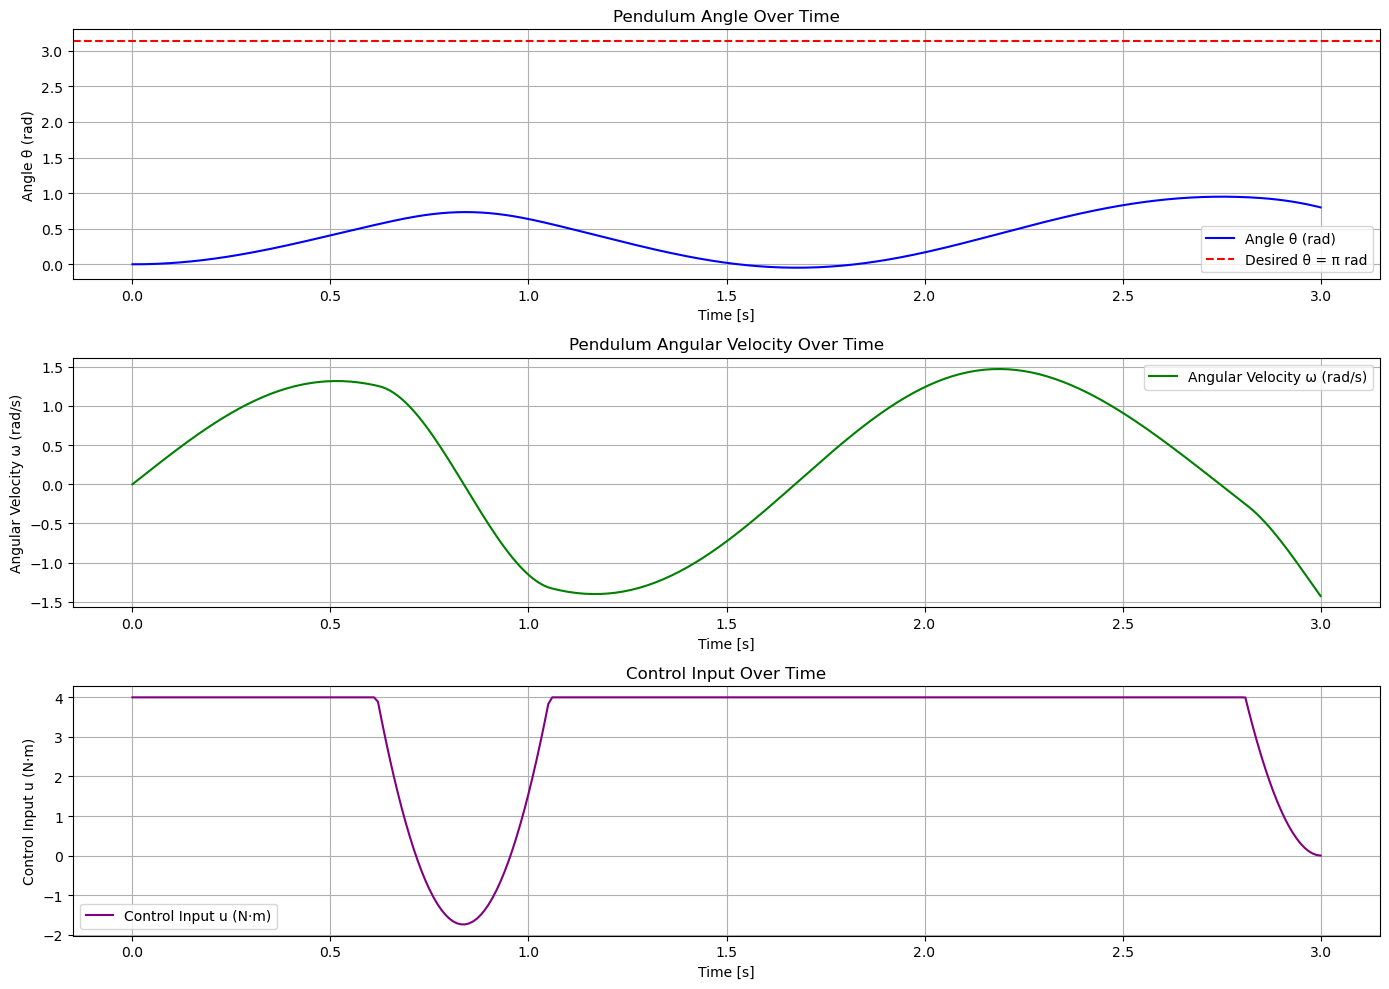

/var/folders/vv/xg94_m256r75qrc_b0bcqy7w0000gn/T/ipykernel_24494/2569952053.py:115: UserWarning: Glyph 7 () missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the main title
/Users/Apple/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


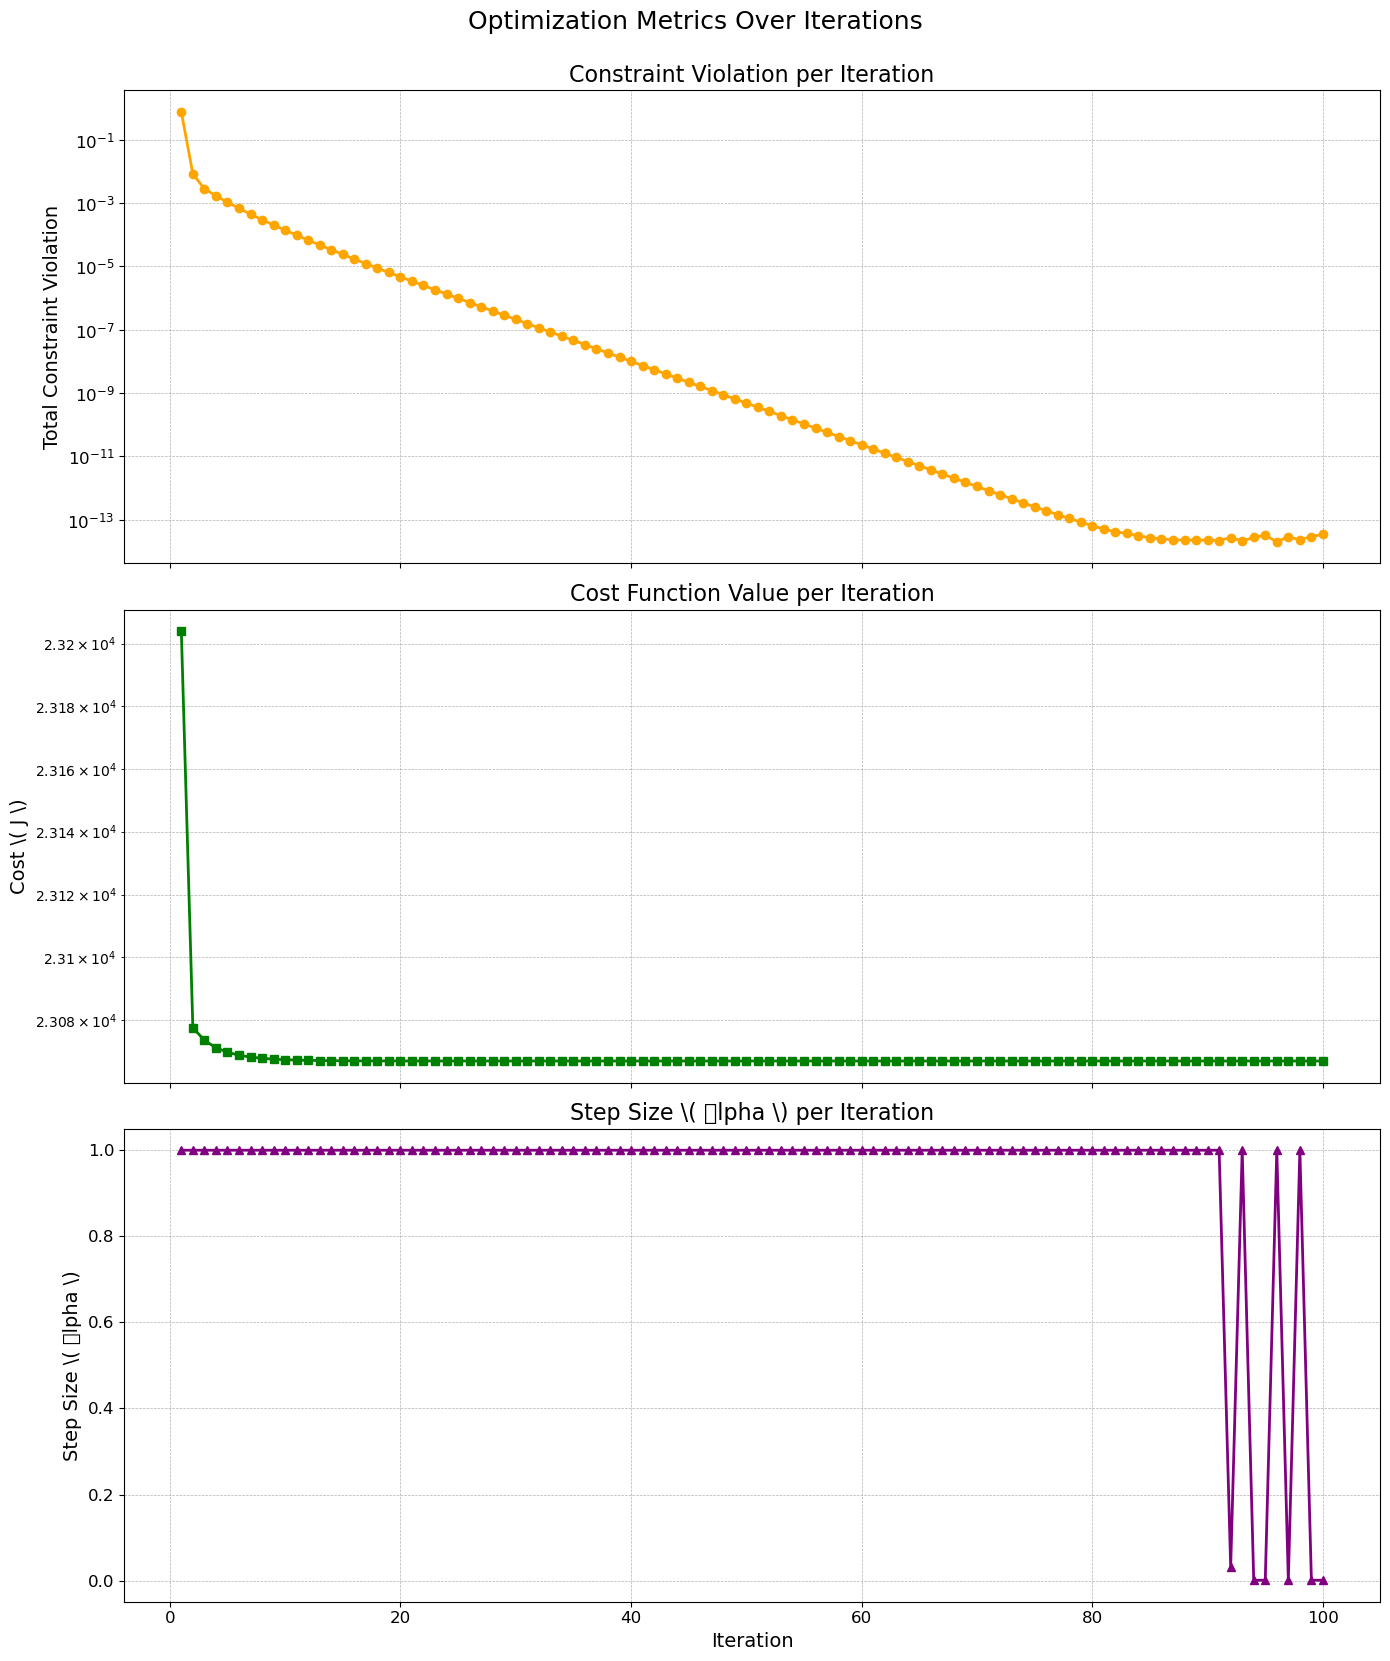

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAApgNtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DPpliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiWxxbaOI12ZNFiDZaGNwvH4gMJme2NhsB
5ycEpJAa5YCClinPEpetz3uLnx008RArAv0e7lBwVdLoRR8HR6ljB55JGV7+XQwNsLbloxnm0Jci
Y1GRGLBEdeoJvx//X6nip2NswUwAubMfy1/YSD/ic5nyOT5RA3uorBCtV2FftGmbYiXunqiOpVpK
I+2r/Ap+Q0WuKVcxKnkzawE1OQzWCRkf+/hKqsKQFeQo8ui0BLWjORcr7fRcv6mtXXQrHNZ5TLXy
vz07HuJ0r1jP1MHeAAstco/y6d/gZv97QP3wjOzkveqCynjnvrx6EsCzZ4ktjM8W1lNaV4DuFxm+
uCz0QBtjwO3A5ZbLNFqrcgL3Ukg4hJjwVAs35DuQE4AAAAMAAAMAAC1tZ+0C8UCh2J0J5/pDiii5
fGN0lno0x71eIwtqvVtzZM5OWEQXCzJMSQ8wkDATruAlQZiLkYQ+di+wiiht8ZvNQdd8uR79qE1F
qvAk5pfFUnaB6zO6UwJib7iwEH6A1bJyuPPGD4rlIqCHsFXguGD2KPA1iP34Qw9JkAnzUcr/k2qn
KRU9EoLbicGmE1AZJwtiVcowVv+c0HKt6+sr5xFpRoDUImMcSRMReLZNXTkCCjy8n6nVH61qJhfm
hCO//LzUoKv77fnrjHfdW6zy0QmHYK98FRJTz1o90MVrW/Ku1u7uRgOuRnNp9LGfmQZvTGf9e6Q2
oms6hL3057RHcGNLz64VFsUozdy0kWmqno8+9da8otXThL9uPiNFrsJrBkwpMol+VB4STEO6WM/M
hEovk/e/h8eWrzX3BarKyfyA6qTDsE8UAAADAAADAAAlS6WQEQ48Job7NXZFUlyBtAepTYmAGtMO
wlHEyTrJrLusB9t0kV5mwYk13luBzCHdd0Tl8TFITDARLM/2lysOIf/37Tuf5iYy2Nc3f5DSPLlL
xX0CmJawL+yX7m+FgnEGuSesh9I0smzZcfWZ9IEZsZskpxRgeZyVuTklHAATTNLwlUNkvrB1wW8h
FfbHDV9tMS8iYnhYiogqKb8Y/MX65GRsw2ccBNw2GtoyErr4dUeo44BSS6jfwusYe2h5UzIdrnxA
0VCmz/TXjkXuZrQamVu/VFxPJ2tSfNKFQ1+USvBTbql7mf8EaZKLRmPZkSMrYeU79fCwTMiEQMh+
D9eNK9XwZcz4BzjOGV+yasNUeZttlAzUylyaL0MdsMrpXLiAapV/f/eYPMB3Zd4wU5eOkhQwrllw
lYReYsrIPZxb+KjvRoAjd3ANk6dxlC/frPfJxCeBAPjUWU/kI7OtsUo9xkrOeo0velpXdnED3yla
4siDZs+ZqWPA8EJt8S8kfzNy7umkPtnBLiRIEVHhqADq+AI7E3hc7/BP4w/GNElLugNVzTJ87vpq
V5Vq+HHi0x9abLz/mkSx++Eeeu2GSAE8BmOabn+2Ym/VqFdcoJ/sWCdY03M6H4KVHFgFeaQAHc1h
9G2sxn8jYVVzURCLX/EGYAiWBQ+WnTDZ6xzCSp0cbcBeRFENm34whFO0KOdlJvzVMaAiJn0iMHtK
681qZWEXw5aIZImXe43X4sr8cLHYoHj39c6bt/sh+/Fi4NeKUGZCQs2DVf7qjtEvRl0zd8BKKPiq
g6wwVIGmCTHv14abTlysUg+jAtPwj00AZNPdSTrXSb2sN/MoocaLdOWsQoQhQ8hXueNdnufNxY4o
KNv9O9/49f/jxHGfKLHhxcn3ROjEc2lq8DzOPm7CkyyYPnK9sjv3MaZxd4FXZBIm27/RpUc7G2QW
i9iDmWpQ2qD6QEkkFTRumNMYE3LLC55z2LAh5Kgnyq/y0lGIoG6yf/2LPC4xsjdOdcedFM8qKSba
OLQEP4u0mfYisM4rFFoXPHOYVYk+RqmSXSfOY8ElMsPsp3hixjYorssUv7Lg3k0so3Rew/JcCemi
WOHsZOpg7peG4TEUE9gmFelXeAJky6kudBWFG8dIZHo+vQz3dn6hRND2I9/piOBXvYiuGzVe7sd/
FEPX/xQCVa7teGn/sbadRlzDXqFqNLAALSg9s7fbCG9AAEv3NWeYpAALaOtD+G2xNkFZbpIKCY5Z
2cLRngvpUoeSBSsfqxjvup5zwDFpAjVpUIMJyutJ6JniVQtSpJO1XkCwjRJW8O3zPRlT+sVYLejJ
OiYgR4m8xB0AErU4CEmmDv/CrhB92pZ7TDQFCIBL047vMbCrVb3qexjQ+HkM5M0dxE+3zNZYI65y
HelyqtkIudbqgLbFKkF25ehGlTfndbj3/T1wwPPbW2Sm7jPOqwGzOntpHwyAEKTNvo82M5kZZrf1
M273JV94fNsC489yQgQSjX6mNeZscxDxG3pcRMiEEiiaClY7O4eMNGUpBJc0TtXyhHRVhGsehYP/
zJFyKoLpcVL9oRQttiC6IEAv+XdUrTEH4gTpAmgIMgzbE6Ea2+DRACh5//CSiU81OHFkWgMQmqhf
LbzyHMPho9LlMKYQ7betaRZ+KvwpMIFul+1jEikdKbJB2SIAHSSyytFDeF+nRV15KqDjIsqMCMIf
D+xX7bKc0hp+EjFS83+rH

In [294]:
%matplotlib inline
plot_solution(theta_opt, omega_opt, u_opt, dt=0.01)
plot(constraint_violation_hist, cost_hist, alpha_hist)

x0 = np.array([[0], [0]])

u_for_animation = u_opt[:-1].reshape(1, -1)

u_for_animation = 4 * np.ones((1, 900))
pendulum.animate_robot(x0, u_for_animation)